<a href="https://colab.research.google.com/github/andrebelem/pythonverse/blob/main/Onda_de_Calor_no_oceano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Onda de Calor no oceano

Autor: [A.L. Belem](https://github.com/andrebelem)<br>
Novembro de 2023<br>


**Pergunta**: "Será que a onda de calor que estamos passando também é vista no oceano ?" 🤔💡


Para responder à essa pergunta eu utilizei o conjunto de dados Multi-scale Ultra-high Resolution (MUR) da JPL (https://lnkd.in/eZtAanJV), abrangendo múltiplos satélites com resolução de aproximadamente 0.01° (ou seja, aprox. 1.1 km 🛰️), que vai de 2002 até o presente, e calculei a média e desvio padrão na área bem na frente da Baia da Guanabara, para formar uma "Climatologia". Também extrai os dados da boia do SiMCosta (a RJ-4) nos últimos 15 dias.


Para fazer este exercício é necessário acessar primeiro os dados do produto `jplMURSST41` no erddap (https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41.html).<br>
Essa parte é bastante demorada e a sugestão é que você "grave" o resultado netcdf depois que baixar do erddap. O comando `gdown` abaixo puxa o arquivo netcdf baixado previamente do erddap.

In [9]:
%%capture
!gdown 19mDNRnS1jvg_J9Nk43WoAkiUjbWHWLz9

In [10]:
import xarray as xr

ds = xr.open_dataset('/content/jplMURSST41.nc')

In [12]:
# verificando se está tudo aqui
ds

<xarray.Dataset>
Dimensions:         (time: 7835, latitude: 1, longitude: 1)
Coordinates:
  * time            (time) datetime64[ns] 2002-06-01T09:00:00 ... 2023-11-16T...
  * latitude        (latitude) float32 -23.17
  * longitude       (longitude) float32 -42.97
Data variables:
    analysed_sst    (time, latitude, longitude) float64 ...
    analysis_error  (time, latitude, longitude) float64 ...
Attributes: (12/50)
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              Grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_name:               JPL MUR SST project
    ...                         ...
    summary:                    This is a merged, multi-sensor L4 Foundation ...
    testOutOfDate:              now-3days
    time_coverage_end:          2023-11-16T09:00:00Z
    time_coverage_start:        2002-06-01T09:00:00Z
    title:                      Multi-scale Ultra-high Resolution (MUR) SST A...
    Westernmost_Easting:        -42.97

In [14]:
import pandas as pd
from datetime import datetime

# note que estou tirando dados dos últimos 15 dias dos dados do simcosta
# obviamente isso pode ser feito automaticamente com o datetime.now()
#time2 = (datetime.now() - datetime(1970, 1, 1)).total_seconds()

time2 = (datetime(2023, 11, 17) - datetime(1970, 1, 1)).total_seconds()
time1 = (datetime(2023, 1, 1) - datetime(1970, 1, 1)).total_seconds()

#print(f'time2 = {int(time2)} \n time1 = {int(time1)}')
# chamando os dados da boia
df = pd.read_json(f'https://simcosta.furg.br/api/oceanic_data?boiaID=12&type=json&time1={int(time1)}&time2={int(time2)}&params=Average_Temperature_deg_C,Average_Temperature_C')
# e aproveitando para transformar tudo em número
df.iloc[:,0:23] = df.iloc[:,0:23].apply(pd.to_numeric,errors='coerce')
# e construindo o array de tempo
df['time'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND']])
df['doy'] = df.time.dt.dayofyear + df.time.dt.hour / 24 + df.time.dt.minute / 1440 + df.time.dt.second / 86400



<ipython-input-14-9f329ade248b>:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,0:23] = df.iloc[:,0:23].apply(pd.to_numeric,errors='coerce')


<Axes: >

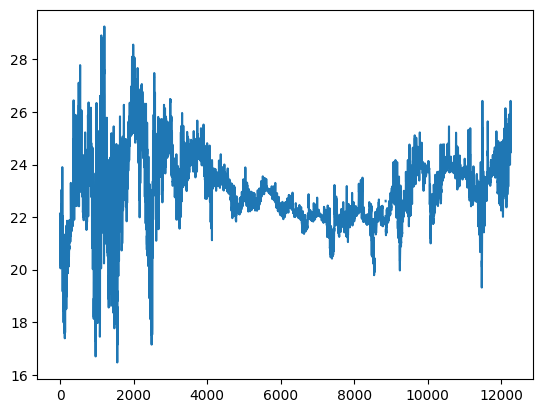

In [15]:
# vamos ver como está a variação da tsm ao longo de todo o ano de 2023
df.Avg_W_Tmp1.plot()

Para fazer o plot, eu uso o seaborn. Esta é apenas uma versão "work" do gráfico que eu quero fazer.

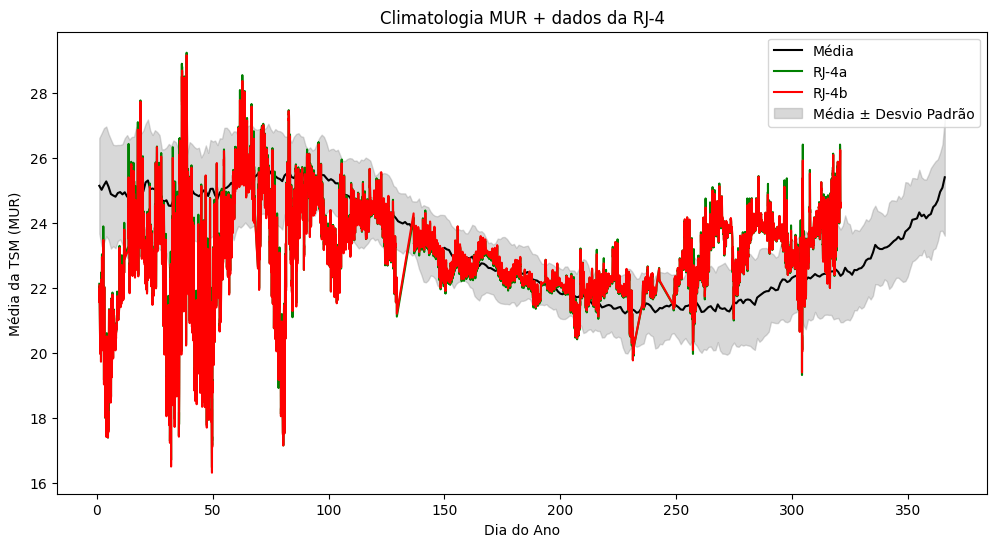

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# Converte o xarray dataset para DataFrame
df_xarray = ds.to_dataframe().reset_index()

# Extraindo o dia do ano da coluna de tempo
df_xarray['day_of_year'] = df_xarray['time'].dt.dayofyear

# Agrupando os dados pelo dia do ano e calculando a média e o desvio padrão
grouped_data = df_xarray.groupby('day_of_year')['analysed_sst'].agg(['mean', 'std']).reset_index()

# Criando o gráfico usando seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='day_of_year', y='mean', color='k',data=grouped_data, label='Média')
sns.lineplot(x='doy',y='Avg_W_Tmp1',color='g',data=df,label='RJ-4a')
sns.lineplot(x='doy',y='Avg_W_Tmp2',color='r',data=df,label='RJ-4b')
plt.fill_between(grouped_data['day_of_year'], grouped_data['mean'] - grouped_data['std'],
                 grouped_data['mean'] + grouped_data['std'], color='grey', alpha=0.3, label='Média ± Desvio Padrão')

# Ajuste dos rótulos e título
plt.xlabel('Dia do Ano')
plt.ylabel('Média da TSM (MUR)')
plt.title('Climatologia MUR + dados da RJ-4')

plt.legend()
plt.show()

Agora montamos o gráfico dos últimos 15 dias, com foco na onda de calor.

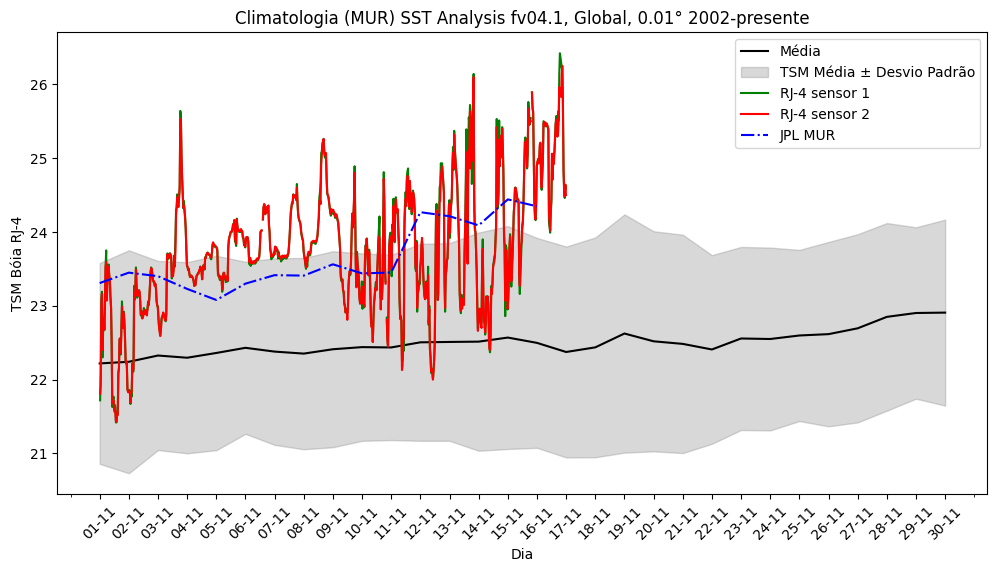

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import matplotlib.dates as mdates

# Extraindo o dia do ano da coluna de tempo apenas para 2023
df_MUR = df_xarray[(df_xarray.time.dt.year==2023)&(df_xarray.day_of_year >= 305)]
df_RJ4 = df[(df.time.dt.year==2023)&(df.doy >= 305)]

# Agrupando os dados pelo dia do ano e calculando a média e o desvio padrão
grouped_data = df_xarray.groupby('day_of_year')['analysed_sst'].agg(['mean', 'std']).reset_index()

# Filtrar dados para o período desejado (01/11 a 30/11)
grouped_data_filtered = grouped_data[(grouped_data['day_of_year'] >= 305) & (grouped_data['day_of_year'] <= 334)]

# seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='day_of_year', y='mean', color='k', data=grouped_data_filtered, label='Média')
plt.fill_between(grouped_data_filtered['day_of_year'], grouped_data_filtered['mean'] - grouped_data_filtered['std'],
                 grouped_data_filtered['mean'] + grouped_data_filtered['std'], color='grey', alpha=0.3, label='TSM Média ± Desvio Padrão')

plt.plot(df_RJ4.doy,df_RJ4.Avg_W_Tmp1,'g',label='RJ-4 sensor 1')
plt.plot(df_RJ4.doy,df_RJ4.Avg_W_Tmp2,'r',label='RJ-4 sensor 2')
plt.plot(df_MUR.day_of_year,df_MUR.analysed_sst,'b-.',label='JPL MUR')


# Ajuste dos rótulos e título
plt.xlabel('Dia')
plt.ylabel('TSM Bóia RJ-4')
plt.title('Climatologia (MUR) SST Analysis fv04.1, Global, 0.01° 2002-presente')

# Formatando rótulos de data
plt.xticks(rotation=45)
plt.xticks(grouped_data_filtered['day_of_year'], pd.to_datetime(grouped_data_filtered['day_of_year'], format='%j').dt.strftime('%d-%m'))
# Adicionando ticks menores (a cada dia)
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())

plt.legend()
plt.show()


# Melhorias

Seria interessante fazer essas tarefas na forma de um dashboard automático, mas para isso, os dados do MUR (que são consideravelmente grandes) deveriam ser previamente baixados e preparados para cada área de interesse.